In [1]:
#%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import math

## SOME FUNCTIONS HAVE BEEN IMPLEMENTED in `estimated_related.py` since they needed to be used again and again

# 2. Two view Geometry

For this task, you have been given two images of the same scene taken from different view-points. Refer to below two images and follow the below points for deliverables:
<br>

*Note: For this question you will need to compute the F matrix on your own without using inbuilt functions. The convention used for F is $x'^{T}Fx$ where $x'$ is the **location of the point in the second image**. File `data/2/camera.txt` has camera parameters in order **Fx, Fy, Cx, Cy, Scaling factor***
<br>


<img src="./data/2/rgb000551.jpg" alt="image 1" width="400"/>
<img src="./data/2/rgb000841.jpg" alt="image 2" width="400"/>


1. Estimate the fundamental matrix from these two images. Clearly, write a function named `compute_fundamental_matrix(X1_list, X2_list)` that takes feature points from first image and corresponding points from second image i.e. known correspondences. You can compute the correspondences either using Feature detector-descriptor + Feature Matching algorithm from openCV or use code provided in DLT part i.e. handcraft them. Save the obtained matrix.

# TASKS

####  Generate the correspondences

In [2]:
import cv2
import importlib
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import numpy as np
import json
import pickle

In [3]:
import helper_utils.dlt_related as dlt_related
importlib.reload(dlt_related)
import helper_utils.annotate_images as img_helper
importlib.reload(img_helper)
import helper_utils.estimation_related as est_related
importlib.reload(est_related)

<module 'helper_utils.estimation_related' from '/home/anmolagarwal/Desktop/mr_assignment_3/helper_utils/estimation_related.py'>

### TODO 7:


3. Based on cheirality, find the correct relative camera pose and clearly mention the same. Visualize 3D camera pose and 3D points together(It's up to you how you come with visualisation).
    

In [4]:
stored_data = dict()
with open('./saved_data/details.pickle', 'rb') as handle:
    stored_data = pickle.load(handle)

In [5]:
stored_data.keys()

dict_keys(['F_want', 'E_matrix', 'R_candidates', 'C_candidates', 'K_mat'])

#### Load the fundamental matrix, candidate poses etc calculated in `q2.ipynb`

In [6]:
F_mat = stored_data['F_want']
E_mat = stored_data['E_matrix']
K_mat = stored_data['K_mat']
R_candidates = stored_data['R_candidates']
C_candidates = stored_data['C_candidates']

In [7]:
f_x = 382.1996765136719
f_y = 381.83956909
c_x = 312.7102355957031
c_y = 247.72047424316406
scaling_fac = 1000.0

In [8]:
K_mat = np.array([
    [f_x, scaling_fac, c_x,0],
    [0, f_y, c_y,0],
    [0, 0, 1,0]
    
])

In [9]:
R0, R1, R2, R3 = R_candidates
C0, C1, C2, C3 = C_candidates

#### Load the pixel coordinates

In [10]:
with open("him_1.json", 'r') as fd:
    px_df_1=json.load(fd)
    px_df_1 = [x.split(",") for x in px_df_1]
    px_df_1 = [[int(y) for y in x] for x in px_df_1]
with open("him_2.json", 'r') as fd:
    px_df_2=json.load(fd)
    px_df_2 = [x.split(",") for x in px_df_2]
    px_df_2 = [[int(y) for y in x] for x in px_df_2]

#### As stated in Zisserman Section 9.6.2, to extract relative pose of camera 2 with respect to camera 1, we choose the R, C for camera 1 to be I, 0. 

In [11]:
def fetch_P_matrix(K, R, C):
    M_ext=np.zeros((4,4))
    M_ext[0:3, 3]=-R@C
    M_ext[0:3, 0:3]= R
    M_ext[-1, -1] = 1
    P_mat = K@M_ext
    return P_mat, M_ext

In [12]:
R_cam_1 = np.identity(3)
C_cam_1 = np.array([0, 0, 0])

In [13]:
P_mat_1, M_ext_1 = fetch_P_matrix(K_mat, R_cam_1, C_cam_1)

In [14]:
with np.printoptions(suppress=True):
    print(P_mat_1)
with np.printoptions(suppress=True):
    print(M_ext_1)

[[ 382.19967651 1000.          312.7102356     0.        ]
 [   0.          381.83956909  247.72047424    0.        ]
 [   0.            0.            1.            0.        ]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


#### Also, to decide the most eligible camera pose, we follow the pipeline defined in the link shared with the assignment ie https://cmsc426.github.io/sfm/
* for each candiate pose, we first triangulate the points. Then, we see that among the triangulated points, which pose has the highest traingulated points in the front. That is the pose we choose.

In [15]:
def LinearTriangulation(P_mat_1,x_img_1,P_mat_2,x_img_2):
    assert(P_mat_1.shape==(3,4))
    assert(P_mat_2.shape==(3,4))
    assert(x_img_1.shape == x_img_2.shape)
    
    num_points = x_img_1.shape[0]
    
    X_world_predicted = []
    
    for px1, px2 in zip(x_img_1, x_img_2):
        best_world_ptx = est_related.fetch_triangulate_point(px1, px2, P_mat_1, P_mat_2)
        best_world_ptx/=best_world_ptx[-1]
        X_world_predicted.append(best_world_ptx)
    return np.array(X_world_predicted)

In [16]:
def homogenize_2d_coordinates(pts_list):
    """Takes a list of 2d points and simply appends 1 to it"""
    new_list = deepcopy(pts_list)
    for curr_elem in new_list:
        curr_elem.append(1)
    new_list = np.array(new_list)
    return new_list

In [17]:
X_img_1 = homogenize_2d_coordinates(px_df_1)
X_img_2 = homogenize_2d_coordinates(px_df_2)

### The BLACK points are the ones lying in front of the camera 2 and the yellow ones are the ones lying at the back of the camera 2.

Total points is  23
Total points in front of camera 2 is:  2


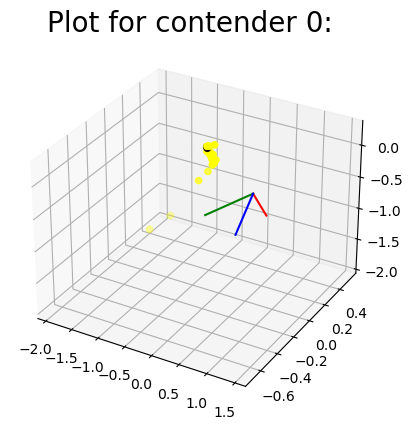

###########################
Total points is  23
Total points in front of camera 2 is:  0


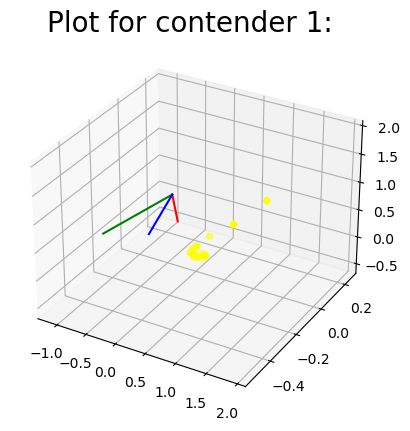

###########################
Total points is  23
Total points in front of camera 2 is:  1


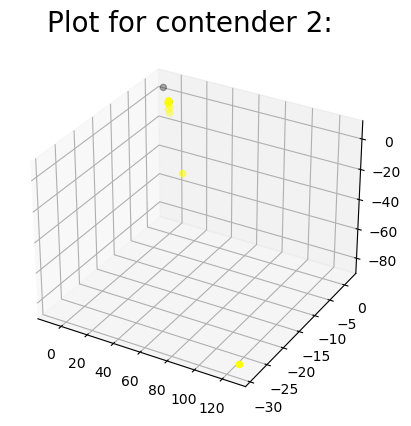

###########################
Total points is  23
Total points in front of camera 2 is:  22


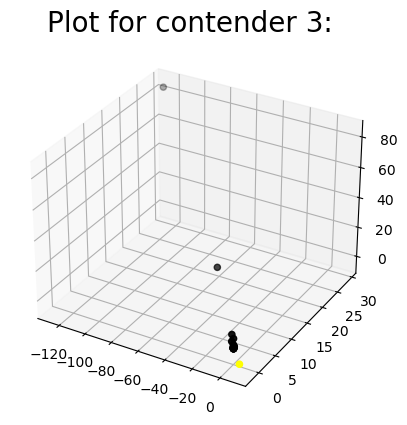

###########################


In [18]:
best_id_yet = -1
max_front = -1

for curr_id in range(4):
    R_mat = R_candidates[curr_id]
    C_vec = C_candidates[curr_id]
    P_mat_2, M_ext_2 = fetch_P_matrix(K_mat, R_mat, C_vec)
    X_world_predicted = LinearTriangulation(P_mat_1, X_img_1, P_mat_2, X_img_2)
    
    # normalize the predictions
    for curr_elem in X_world_predicted:
        curr_elem/=curr_elem[-1]
        
    # count number of points which are in front of the camera
    num_in_front = 0
    
    # draw as well
    r3 = R_mat[2,:]
    t_val = []
    col_val = []
    for curr_elem in X_world_predicted:
        #print(curr_elem)
        res = curr_elem[:3]-C_vec
        #with np.printoptions(suppress=True): print(res)
        val = np.dot(r3, res)
        #print("val is ", val>0)
        t_val.append(val>0 and curr_elem[2]>0)
        if t_val[-1]==True:
            num_in_front+=1
            col_val.append('black')
        else:
            col_val.append('yellow')
            
    ###############################
    # Arrangements for plotting
    origin = M_ext_2@np.array([0, 0, 0, 1])
    x_lim = M_ext_2@np.array([0.5, 0, 0, 1])
    y_lim = M_ext_2@np.array([0, 0.5, 0, 1])
    z_lim = M_ext_2@np.array([0, 0, 0.5, 1])



    for a in [origin, x_lim, y_lim, z_lim]:
        a/=a[-1]
        
    ax = plt.axes(projection='3d')

    xdata = X_world_predicted[:, 0]
    ydata = X_world_predicted[:, 1]
    zdata = X_world_predicted[:, 2]

    ax.scatter3D(xdata, ydata, zdata,c=col_val)

    plt.title(f"Plot for contender {curr_id}: ", fontdict={'fontsize': 20})
    
    print("Total points is ",X_world_predicted.shape[0])
    print("Total points in front of camera 2 is: ", num_in_front)
    # plotting
    ax.plot3D([origin[0],x_lim[0] ], [origin[1],x_lim[1] ], [origin[2],x_lim[2] ], color='red')
    ax.plot3D([origin[0],y_lim[0] ], [origin[1],y_lim[1] ], [origin[2],y_lim[2] ], color='green')
    ax.plot3D([origin[0],z_lim[0] ], [origin[1],z_lim[1] ], [origin[2],z_lim[2] ], color='blue')
    plt.show()
    ax.clear()
    
    if num_in_front>=max_front:
        max_front = num_in_front
        best_id_yet = curr_id           
    print("###########################")

In [19]:
best_id_yet 

3

## We see that the last candidate ie candidate ID:`3` performs the best

#### Now, plotting the cameras

<IPython.core.display.Javascript object>


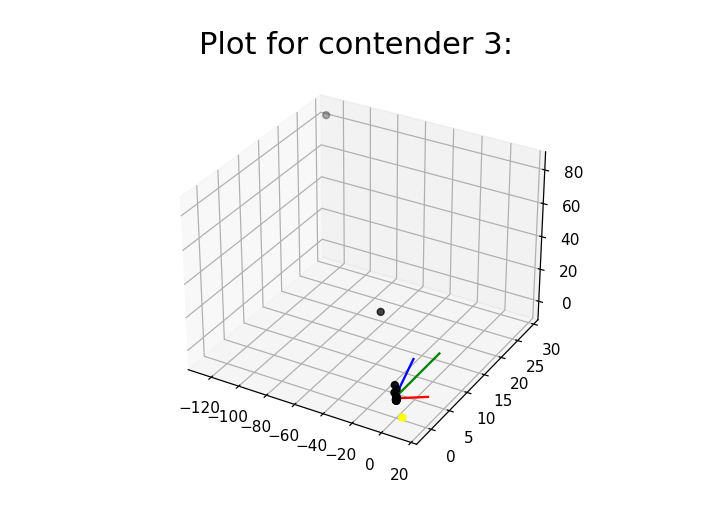

Total points is  23
Total points in front of camera 2 is:  22


In [20]:
%matplotlib notebook


curr_id = best_id_yet

R_mat = R_candidates[curr_id]
C_vec = C_candidates[curr_id]
P_mat_2, M_ext_2 = fetch_P_matrix(K_mat, R_mat, C_vec)
X_world_predicted = LinearTriangulation(P_mat_1, X_img_1, P_mat_2, X_img_2)

# normalize the predictions
for curr_elem in X_world_predicted:
    curr_elem/=curr_elem[-1]

# count number of points which are in front of the camera
num_in_front = 0

# draw as well
r3 = R_mat[2,:]
t_val = []
col_val = []
for curr_elem in X_world_predicted:
    #print(curr_elem)
    res = curr_elem[:3]-C_vec
    #with np.printoptions(suppress=True): print(res)
    val = np.dot(r3, res)
    #print("val is ", val>0)
    t_val.append(val>0 and curr_elem[2]>0)
    if t_val[-1]==True:
        num_in_front+=1
        col_val.append('black')
    else:
        col_val.append('yellow')

###############################
# Arrangements for plotting
origin = M_ext_2@np.array([0, 0, 0, 1])
x_lim = M_ext_2@np.array([15, 0, 0, 1])
y_lim = M_ext_2@np.array([0, 15, 0, 1])
z_lim = M_ext_2@np.array([0, 0, 15, 1])



for a in [origin, x_lim, y_lim, z_lim]:
    a/=a[-1]

ax = plt.axes(projection='3d')

xdata = X_world_predicted[:, 0]
ydata = X_world_predicted[:, 1]
zdata = X_world_predicted[:, 2]

ax.scatter3D(xdata, ydata, zdata,c=col_val)

plt.title(f"Plot for contender {curr_id}: ", fontdict={'fontsize': 20})

print("Total points is ",X_world_predicted.shape[0])
print("Total points in front of camera 2 is: ", num_in_front)
# plotting
ax.plot3D([origin[0],x_lim[0] ], [origin[1],x_lim[1] ], [origin[2],x_lim[2] ], color='red')
ax.plot3D([origin[0],y_lim[0] ], [origin[1],y_lim[1] ], [origin[2],y_lim[2] ], color='green')
ax.plot3D([origin[0],z_lim[0] ], [origin[1],z_lim[1] ], [origin[2],z_lim[2] ], color='blue')
plt.show()


In [21]:
origin - x_lim

array([-14.40961163,  -3.34239371,   2.48827189,   0.        ])

In [22]:
np.dot(origin - x_lim,origin-y_lim)

-6.572520305780927e-14

In [23]:
np.dot(origin - z_lim,origin-y_lim)

0.0

In [24]:
np.dot(origin - z_lim,origin-x_lim)

2.1316282072803006e-14

<img src="./saved_data/contender_3.png" alt="image 2" width="400"/>


In [25]:
X_world_predicted = X_world_predicted[:, :-1]

In [26]:
X_world_predicted.shape

(23, 3)

### Save pcl

In [27]:
import math
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
import copy
from matplotlib.image import imread

In [28]:
import open3d as o3d
import numpy as np
pcl = o3d.geometry.PointCloud()
pcl.points = o3d.utility.Vector3dVector(X_world_predicted)
o3d.visualization.draw_geometries([pcl])